In [1]:
import cmocean
import logging
import itertools
import numpy as np
import seaborn as sns
#import dask.array as da
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#from dask import delayed, compute
from scipy.interpolate import interp2d
#from dask.distributed import Client, progress
from matplotlib.colors import LogNorm, TwoSlopeNorm, SymLogNorm, Normalize

sns.set()
sns.set_style("ticks")

In [2]:
from spectral_analysis.filtering import filter_fft_butterworth_omega
from spectral_analysis.common_vars.time_slices import idx_t
from spectral_analysis.common_vars.directories import LUIGI_OUT_FOLDER,POSTPROCESS_OUT_FOLDER
from spectral_analysis.common_vars.regions import ids_regions,lats4id,lons4id,faces_regions
#from spectral_analysis.isotropic_spectra.spectral_kinema import spectral_kinematics
#from spectral_analysis.isotropic_spectra.isotropic import calc_ispec
from spectral_analysis.luigi_workflows.llc_region import LLCRegion
from spectral_analysis.luigi_workflows.output import VorticityGrid

In [3]:
%load_ext autoreload
%autoreload

In [4]:
from importlib import reload
import spectral_analysis
reload(spectral_analysis)
reload(spectral_analysis.filtering)
from spectral_analysis.filtering import filter_fft_butterworth_omega
import spectral_analysis.luigi_workflows.output
reload(spectral_analysis.luigi_workflows.output)
from spectral_analysis.luigi_workflows.output import VorticityGrid
import spectral_analysis.luigi_workflows
reload(spectral_analysis.luigi_workflows)
import spectral_analysis.luigi_workflows.llc_region
reload(spectral_analysis.luigi_workflows.llc_region)
from spectral_analysis.luigi_workflows.llc_region import LLCRegion

In [5]:
import logging
logging.basicConfig(
    format="%(asctime)s %(levelname)-8s %(message)s",
    level=logging.DEBUG,
    datefmt="%Y-%m-%d %H:%M:%S")

#logging.getLogger("matplotlib.font_manager").setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.ticker').disabled = True

In [6]:
season = "JFM"
region = "Canarias"
rid = ids_regions[region][2]
region = LLCRegion(rid, idx_t["hours"][season][30:31], tag=season)

2021-08-26 11:00:54 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2021-08-26 11:00:54 INFO     Exists? 730: _JFM -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/730_JFM_hours.npz
2021-08-26 11:00:55 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km']


In [7]:
XC, YC = region.getGridC()
XG, YG = region.getGridG()

In [8]:
region.loadScalar("U")
region.loadScalar("V")

2021-08-26 10:39:28 INFO     Loading U: shape (k=0): (290, 289, 1)
2021-08-26 10:39:28 INFO     Loading V: shape (k=0): (290, 289, 1)


In [9]:
U_ = region.get("U")[:,:,0]
V_ = region.get("V")[:,:,0]

In [10]:
print(XC.shape, YC.shape)
print(XG.shape, YG.shape)
print(U_.shape, V_.shape)

(290, 289) (290, 289)
(290, 289) (290, 289)
(290, 289) (290, 289)


In [11]:
nmax=-1
print("XG", np.min(XG), np.max(XG))
print("XC", np.min(XC), np.max(XC))
print("XC*", np.min(XC[::,:nmax]), np.max(XC[::,:nmax]))
print("YG", np.min(YG), np.max(YG))
print("YC", np.min(YC), np.max(YC))
print("YC*", np.min(YC[:nmax,::]), np.max(YC[:nmax,::]))

XG -26.0 -20.0
XC -25.989584 -19.989584
XC* -25.989584 -20.010416
YG 19.032818 24.17676
YC 19.041874 24.185495
YC* 19.041874 24.168024


In [12]:
def plot_uv(U__, V__):
  with sns.axes_style("whitegrid"):
    min_vel = min(np.min(U__), np.min(V__))
    max_vel = max(np.max(U__), np.max(V__))
    norm = TwoSlopeNorm(vmin=min_vel, vmax=max_vel, vcenter=0)
    cmap = plt.cm.RdBu_r
    #
    plt.figure()
    plt.pcolormesh(XG, YC, U__, norm=norm, cmap=cmap)
    plt.colorbar()
    plt.show()
    #
    plt.figure()
    plt.pcolormesh(XC, YG, V__, norm=norm, cmap=cmap)
    plt.colorbar()
    plt.show()
    #
    plt.figure(figsize=(10,10))
    nn_=5
    plt.quiver(XC[::nn_,::nn_], YC[::nn_,::nn_], U__[::nn_,::nn_], V__[::nn_,::nn_])
    plt.show()

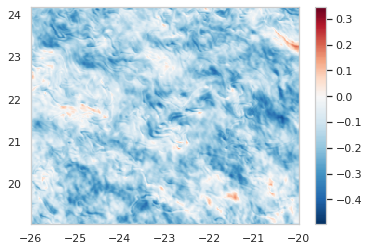

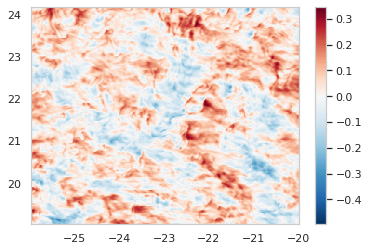

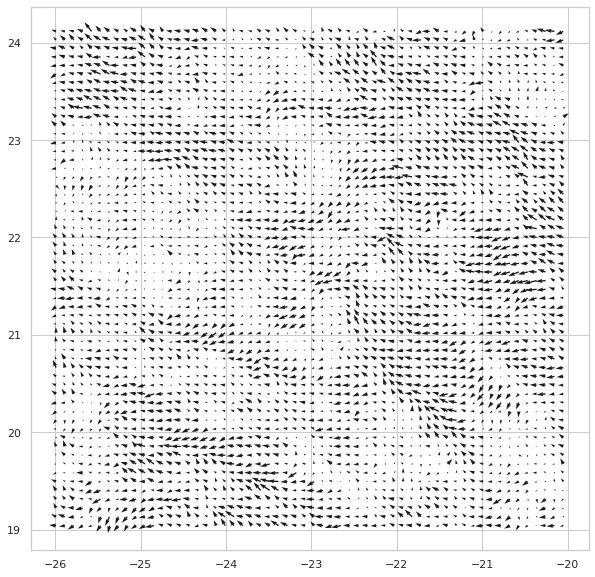

In [13]:
plot_uv(U_, V_)

In [12]:
def interpolate_mesh(Xi, Yi, F, X, Y, kind='linear'):
    print("local F.size: ", F.size)
    interpolant = interp2d(Xi, Yi, F, kind=kind)
    res = [interpolant(x,y) for x,y in zip(X, Y)]
    return np.reshape(res, X.shape)

In [ ]:
%time U = interpolate_mesh(XG, YC, U_, XC.ravel(), YC.ravel())

In [ ]:
%time V = interpolate_mesh(XC, YG, V_, XC.ravel(), YC.ravel())

In [ ]:
print("shape UV", U.shape, V.shape)

In [ ]:
plot_uv(U, V)

In [ ]:
print("Umin", np.min(U_), np.min(U))
print("Umax", np.max(U_), np.max(U))
print("Vmin", np.min(V_), np.min(V))
print("Vmax", np.max(V_), np.max(V))

## Horizontal advection

In [8]:
reg_ = LLCRegion(rid, idx_t["hours"][season], tag=season)

2021-08-26 11:01:05 INFO     Grid: dx = 2.1525167858620695 km, dy = 1.9787329799999998 km, dt = 1 h
2021-08-26 11:01:05 INFO     Exists? 730: _JFM -- Filename /mnt/disks/LLC4320/Postprocess/wk_spectra/730_JFM_hours.npz
2021-08-26 11:01:05 INFO     Spectra - Variables: ['om', 'k_h', 'KE', 'KE_RV', 'KE_DIV', 'KE_k', 'RV_k', 'DIV_k', 'Lt_km']


In [32]:
advU, advV = reg_.adv_2d("adv")

2021-08-26 10:51:47 INFO     Loading U: shape (k=0): (290, 289, 2184)
2021-08-26 10:51:54 INFO     Loading V: shape (k=0): (290, 289, 2184)
2021-08-26 10:52:02 INFO     Calculating adv_x = (U*grad_x)U + (V*grad_y)U
2021-08-26 10:52:08 INFO     Calculating adv_y = (U*grad_x)V + (V*grad_y)V


In [16]:
print("shape adv_UV", advU.shape, advV.shape)

shape adv_UV (290, 289, 2184) (290, 289, 2184)


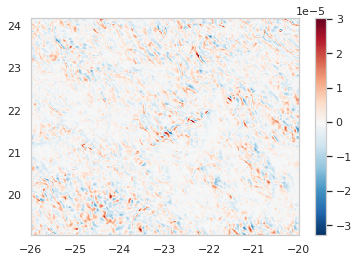

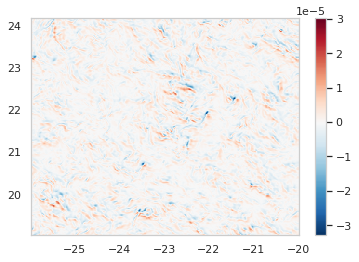

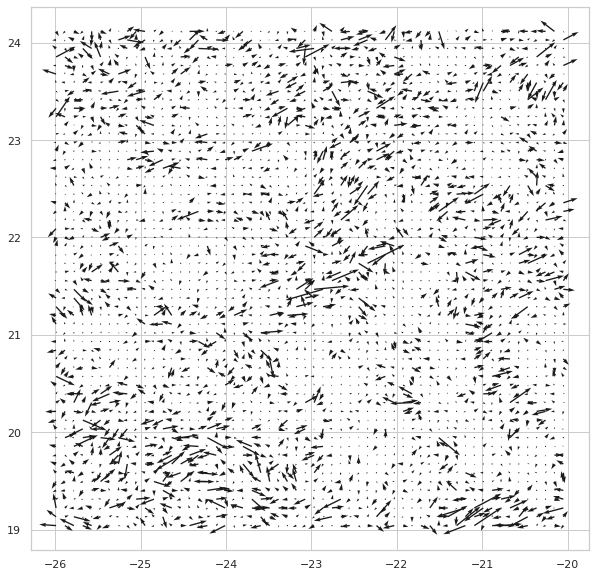

In [17]:
tt = 10
plot_uv(advU[:,:,tt], advV[:,:,tt])

### Energy transfer

In [9]:
xlims = [1/150,1/8]
xticks = [1/10,1/25,1/50,1/80,1/150]
xticksLabel = ['10','25','50','80','150']
yticks = [1/3,1/6,1/12,1/24,1/(24*7),1/(24*30)]
yticksLabel = ['3 h','6 h','12 h','1 d','1 w','1 mo']
# Lt plots
xticks_ = [1/10,1/20,1/30,1/40,1/50,1/75,1/100,1/150]
xticksLabel_ = ['10','20','30','40','50','75','100','150']

def plot_cospectra(ki, omega, S, title, linthresh=5e-11, cmap='bwr', vminmax=None, bottom=False, k_scale=True):
    logging.info("{} - {} (type={}), {} (type={}), {} (type={})".format(title, S.shape, S.dtype, omega.shape, omega.dtype, ki.shape, ki.dtype))
    plt.figure(figsize=(8,6))
    SS = (omega*S).T*ki if k_scale else S.T
    if vminmax is None:
        vmin = np.min(abs(SS))
        vmax = np.max(abs(SS))
    else:
        vmin=vminmax[0]
        vmax=vminmax[1]
    vcenter = (vmin+vmax)/2 if vmin>=0 else 0
    print("Vminmaxcenter",vmin,vmax,vcenter)
    #norm = TwoSlopeNorm(vmin=vmin, vmax=vmax, vcenter=vcenter)
    norm = SymLogNorm(linthresh, vmin=vmin, vmax=vmax, base=10)
    logging.info("SS: {}, vminmax = {}".format(SS.shape, vminmax))
    plt.pcolormesh(ki, omega, SS, norm=norm, cmap=cmap)
    plt.xscale('log')
    plt.xticks(xticks,xticksLabel)
    plt.xlim(xlims)
    plt.yscale('log')
    plt.ylim([omega[1],omega[-100]])
    plt.yticks(yticks,yticksLabel)
    plt.colorbar()
    if bottom:
      plt.xlabel('Horizontal scales [km]', size='large')
    plt.ylabel('Time scales', size='large')
    plt.title(title, size='x-large')
    #plt.show()

In [10]:
def calc_adv_cospec2d(region_, fromS="", toS="", coS=""):
  uName = "U"+fromS
  vName = "V"+fromS
  fxName = "U"+toS
  fyName = "V"+toS
  uNameCo = "U"+coS
  vNameCo = "V"+coS
  advName = "adv{}{}".format(fromS,toS)
  advSuffix=coS+fromS+toS
  adv_k_name = "ADV"+advSuffix
  
  advU_, advV_ = region_.adv_2d(advName, uName=uName, vName=vName, fxName=fxName, fyName=fyName)
  logging.info("shape {}_UV: {}, {}".format(advName, advU_.shape, advU_.shape))
  
  reg_.cospectrum(advName+"_x", uNameCo, adv_k_name+"_x")
  reg_.cospectrum(advName+"_y", vNameCo, adv_k_name+"_y")
  adv_S_ = region_.get_spectrum(adv_k_name+"_x") + region_.get_spectrum(adv_k_name+"_y")

  ki = region_.get_spectrum("k_h")
  omega = region_.get_spectrum("om")
  logging.info("K: ({}, {})".format(np.min(ki), np.max(ki)))
  logging.info("omega: ({}, {})".format(np.min(omega), np.max(omega)))
  logging.info("{}($\omega$,k) shape: {}".format(adv_k_name, adv_S_.shape))
  logging.info("ADV range --> min: {} max: {}".format(np.min(adv_S_), np.max(adv_S_)))

  plot_cospectra(ki, omega, -adv_S_[:,:], adv_k_name+"($\omega$,k)", linthresh=1e-10, vminmax=[-5e-7,5e-7], bottom=True)

2021-08-26 10:52:16 INFO     (adv_x,adv_y) already there!
2021-08-26 10:52:16 INFO     shape adv_UV: (290, 289, 2184), (290, 289, 2184)
2021-08-26 10:52:16 INFO     Calculating ADV_x = FFT(adv_x)*FFT(U)^*


before fftn
290 289 2184


2021-08-26 10:52:43 INFO     Saved ADV_x((144, 1093)). min: -0.007053509155895655, max: 0.0005808532977615138
2021-08-26 10:52:43 INFO     Calculating ADV_y = FFT(adv_y)*FFT(V)^*


before fftn
290 289 2184


2021-08-26 10:53:09 INFO     Saved ADV_y((144, 1093)). min: -0.0001893244956235285, max: 0.0022182456832650715
2021-08-26 10:53:09 INFO     K: (0.0008009869852624585, 0.22988326477032558)
2021-08-26 10:53:09 INFO     omega: (0.0, 0.5)
2021-08-26 10:53:09 INFO     ADV($\omega$,k) shape: (144, 1093)
2021-08-26 10:53:09 INFO     ADV range --> min: -0.006070157190425635 max: 0.0015786887751641004
2021-08-26 10:53:09 INFO     ADV($\omega$,k) - (144, 1093) (type=float64), (1093,) (type=float64), (144,) (type=float64)
2021-08-26 10:53:09 INFO     SS: (1093, 144), vminmax = [-5e-07, 5e-07]


Vminmaxcenter -5e-07 5e-07 0


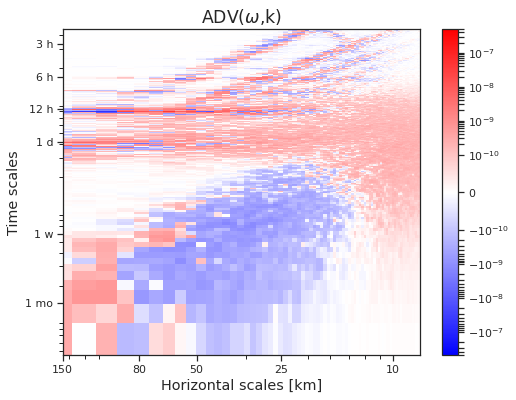

In [35]:
calc_adv_cospec2d(reg_)

### Filtering above/below 30 h

In [11]:
grid = VorticityGrid(rid)

In [14]:
reg_.loadScalar("U")
reg_.loadScalar("V")
UU = reg_.get("U")
VV = reg_.get("V")

2021-08-26 11:01:43 INFO     Loading U: shape (k=0): (290, 289, 2184)
2021-08-26 11:02:02 INFO     Loading V: shape (k=0): (290, 289, 2184)


In [15]:
U_lf,U_hf = filter_fft_butterworth_omega(UU,cuttoff_h=30)
V_lf,V_hf = filter_fft_butterworth_omega(VV,cuttoff_h=30)

2021-08-26 11:02:15 INFO     omega BW -- shape: (290, 289, 2184)
2021-08-26 11:02:27 INFO     omega BW -- shape: (290, 289, 2184)


In [16]:
reg_.set(U_lf,"U_bm")
reg_.set(U_hf,"U_igw")
reg_.set(V_lf,"V_bm")
reg_.set(V_hf,"V_igw")
del U_lf,V_lf,U_hf,V_hf

2021-08-26 11:02:39 INFO     Calculating adv_bm_bm_x = (U_bm*grad_x)U_bm + (V_bm*grad_y)U_bm
2021-08-26 11:02:44 INFO     Calculating adv_bm_bm_y = (U_bm*grad_x)V_bm + (V_bm*grad_y)V_bm
2021-08-26 11:02:49 INFO     shape adv_bm_bm_UV: (290, 289, 2184), (290, 289, 2184)
2021-08-26 11:02:49 INFO     Calculating ADV_bm_bm_bm_x = FFT(adv_bm_bm_x)*FFT(U_bm)^*


before fftn
290 289 2184


/home/antonimmo/github/ocean-wk-spectral-analysis/spectral_analysis/isotropic_spectra/co_spec.py:29: RuntimeWarning: invalid value encountered in sqrt
  cospec_rms = np.sqrt((cospec_dens[1:,1:,1:-2].sum()*df1*df2*df3))
2021-08-26 11:03:17 INFO     Saved ADV_bm_bm_bm_x((144, 1093)). min: -0.006635050727217707, max: 0.0009391361551006303
2021-08-26 11:03:17 INFO     Calculating ADV_bm_bm_bm_y = FFT(adv_bm_bm_y)*FFT(V_bm)^*


before fftn
290 289 2184


2021-08-26 11:03:45 INFO     Saved ADV_bm_bm_bm_y((144, 1093)). min: -0.00012365943156658008, max: 0.00209900698670286
2021-08-26 11:03:45 INFO     K: (0.0008009869852624585, 0.22988326477032558)
2021-08-26 11:03:45 INFO     omega: (0.0, 0.5)
2021-08-26 11:03:45 INFO     ADV_bm_bm_bm($\omega$,k) shape: (144, 1093)
2021-08-26 11:03:45 INFO     ADV range --> min: -0.005834393322254854 max: 0.0019076268080530543
2021-08-26 11:03:45 INFO     ADV_bm_bm_bm($\omega$,k) - (144, 1093) (type=float64), (1093,) (type=float64), (144,) (type=float64)
2021-08-26 11:03:45 INFO     SS: (1093, 144), vminmax = [-5e-07, 5e-07]
2021-08-26 11:03:45 INFO     (adv_bm_bm_x,adv_bm_bm_y) already there!
2021-08-26 11:03:45 INFO     shape adv_bm_bm_UV: (290, 289, 2184), (290, 289, 2184)
2021-08-26 11:03:45 INFO     Calculating ADV_igw_bm_bm_x = FFT(adv_bm_bm_x)*FFT(U_igw)^*


Vminmaxcenter -5e-07 5e-07 0
before fftn
290 289 2184


2021-08-26 11:04:12 INFO     Saved ADV_igw_bm_bm_x((144, 1093)). min: -1.194983616293867e-06, max: 2.8705236462871386e-05
2021-08-26 11:04:12 INFO     Calculating ADV_igw_bm_bm_y = FFT(adv_bm_bm_y)*FFT(V_igw)^*


before fftn
290 289 2184


2021-08-26 11:04:40 INFO     Saved ADV_igw_bm_bm_y((144, 1093)). min: -1.0110033834235277e-06, max: 6.450436944292197e-06
2021-08-26 11:04:40 INFO     K: (0.0008009869852624585, 0.22988326477032558)
2021-08-26 11:04:40 INFO     omega: (0.0, 0.5)
2021-08-26 11:04:40 INFO     ADV_igw_bm_bm($\omega$,k) shape: (144, 1093)
2021-08-26 11:04:40 INFO     ADV range --> min: -1.6391021943702222e-06 max: 3.515567340716358e-05
2021-08-26 11:04:40 INFO     ADV_igw_bm_bm($\omega$,k) - (144, 1093) (type=float64), (1093,) (type=float64), (144,) (type=float64)
2021-08-26 11:04:40 INFO     SS: (1093, 144), vminmax = [-5e-07, 5e-07]
2021-08-26 11:04:40 INFO     Calculating adv_bm_igw_x = (U_bm*grad_x)U_igw + (V_bm*grad_y)U_igw


Vminmaxcenter -5e-07 5e-07 0


2021-08-26 11:04:46 INFO     Calculating adv_bm_igw_y = (U_bm*grad_x)V_igw + (V_bm*grad_y)V_igw
2021-08-26 11:04:51 INFO     shape adv_bm_igw_UV: (290, 289, 2184), (290, 289, 2184)
2021-08-26 11:04:51 INFO     Calculating ADV_bm_bm_igw_x = FFT(adv_bm_igw_x)*FFT(U_bm)^*


before fftn
290 289 2184


2021-08-26 11:05:19 INFO     Saved ADV_bm_bm_igw_x((144, 1093)). min: -0.006635050727217707, max: 0.0009391361551006303
2021-08-26 11:05:19 INFO     Calculating ADV_bm_bm_igw_y = FFT(adv_bm_igw_y)*FFT(V_bm)^*


before fftn
290 289 2184


2021-08-26 11:05:46 INFO     Saved ADV_bm_bm_igw_y((144, 1093)). min: -0.00012365943156658008, max: 0.00209900698670286
2021-08-26 11:05:46 INFO     K: (0.0008009869852624585, 0.22988326477032558)
2021-08-26 11:05:46 INFO     omega: (0.0, 0.5)
2021-08-26 11:05:46 INFO     ADV_bm_bm_igw($\omega$,k) shape: (144, 1093)
2021-08-26 11:05:46 INFO     ADV range --> min: -0.005834393322254854 max: 0.0019076268080530543
2021-08-26 11:05:46 INFO     ADV_bm_bm_igw($\omega$,k) - (144, 1093) (type=float64), (1093,) (type=float64), (144,) (type=float64)
2021-08-26 11:05:46 INFO     SS: (1093, 144), vminmax = [-5e-07, 5e-07]
2021-08-26 11:05:46 INFO     (adv_bm_igw_x,adv_bm_igw_y) already there!
2021-08-26 11:05:46 INFO     shape adv_bm_igw_UV: (290, 289, 2184), (290, 289, 2184)
2021-08-26 11:05:46 INFO     Calculating ADV_igw_bm_igw_x = FFT(adv_bm_igw_x)*FFT(U_igw)^*


Vminmaxcenter -5e-07 5e-07 0
before fftn
290 289 2184


2021-08-26 11:06:13 INFO     Saved ADV_igw_bm_igw_x((144, 1093)). min: -1.194983616293867e-06, max: 2.8705236462871386e-05
2021-08-26 11:06:13 INFO     Calculating ADV_igw_bm_igw_y = FFT(adv_bm_igw_y)*FFT(V_igw)^*


before fftn
290 289 2184


2021-08-26 11:06:42 INFO     Saved ADV_igw_bm_igw_y((144, 1093)). min: -1.0110033834235277e-06, max: 6.450436944292197e-06
2021-08-26 11:06:42 INFO     K: (0.0008009869852624585, 0.22988326477032558)
2021-08-26 11:06:42 INFO     omega: (0.0, 0.5)
2021-08-26 11:06:42 INFO     ADV_igw_bm_igw($\omega$,k) shape: (144, 1093)
2021-08-26 11:06:42 INFO     ADV range --> min: -1.6391021943702222e-06 max: 3.515567340716358e-05
2021-08-26 11:06:42 INFO     ADV_igw_bm_igw($\omega$,k) - (144, 1093) (type=float64), (1093,) (type=float64), (144,) (type=float64)
2021-08-26 11:06:42 INFO     SS: (1093, 144), vminmax = [-5e-07, 5e-07]
2021-08-26 11:06:42 INFO     Calculating adv_igw_bm_x = (U_igw*grad_x)U_bm + (V_igw*grad_y)U_bm


Vminmaxcenter -5e-07 5e-07 0


2021-08-26 11:06:46 INFO     Calculating adv_igw_bm_y = (U_igw*grad_x)V_bm + (V_igw*grad_y)V_bm
2021-08-26 11:06:51 INFO     shape adv_igw_bm_UV: (290, 289, 2184), (290, 289, 2184)
2021-08-26 11:06:51 INFO     Calculating ADV_bm_igw_bm_x = FFT(adv_igw_bm_x)*FFT(U_bm)^*


before fftn
290 289 2184


2021-08-26 11:07:21 INFO     Saved ADV_bm_igw_bm_x((144, 1093)). min: -0.00042267565741533166, max: 8.899215246867694e-05
2021-08-26 11:07:21 INFO     Calculating ADV_bm_igw_bm_y = FFT(adv_igw_bm_y)*FFT(V_bm)^*


before fftn
290 289 2184


2021-08-26 11:07:49 INFO     Saved ADV_bm_igw_bm_y((144, 1093)). min: -6.71728563695473e-05, max: 0.00018262170530299935
2021-08-26 11:07:49 INFO     K: (0.0008009869852624585, 0.22988326477032558)
2021-08-26 11:07:49 INFO     omega: (0.0, 0.5)
2021-08-26 11:07:49 INFO     ADV_bm_igw_bm($\omega$,k) shape: (144, 1093)
2021-08-26 11:07:49 INFO     ADV range --> min: -0.00033762601776095167 max: 2.883004333010271e-05
2021-08-26 11:07:49 INFO     ADV_bm_igw_bm($\omega$,k) - (144, 1093) (type=float64), (1093,) (type=float64), (144,) (type=float64)
2021-08-26 11:07:49 INFO     SS: (1093, 144), vminmax = [-5e-07, 5e-07]
2021-08-26 11:07:49 INFO     (adv_igw_bm_x,adv_igw_bm_y) already there!
2021-08-26 11:07:49 INFO     shape adv_igw_bm_UV: (290, 289, 2184), (290, 289, 2184)
2021-08-26 11:07:49 INFO     Calculating ADV_igw_igw_bm_x = FFT(adv_igw_bm_x)*FFT(U_igw)^*


Vminmaxcenter -5e-07 5e-07 0
before fftn
290 289 2184


2021-08-26 11:08:18 INFO     Saved ADV_igw_igw_bm_x((144, 1093)). min: -2.0155681520046082e-05, max: 8.29318294166091e-05
2021-08-26 11:08:18 INFO     Calculating ADV_igw_igw_bm_y = FFT(adv_igw_bm_y)*FFT(V_igw)^*


before fftn
290 289 2184


2021-08-26 11:08:46 INFO     Saved ADV_igw_igw_bm_y((144, 1093)). min: -7.731210236244703e-05, max: 5.907498644328045e-05
2021-08-26 11:08:46 INFO     K: (0.0008009869852624585, 0.22988326477032558)
2021-08-26 11:08:46 INFO     omega: (0.0, 0.5)
2021-08-26 11:08:46 INFO     ADV_igw_igw_bm($\omega$,k) shape: (144, 1093)
2021-08-26 11:08:46 INFO     ADV range --> min: -3.57529188655476e-05 max: 0.00010229782127774137
2021-08-26 11:08:46 INFO     ADV_igw_igw_bm($\omega$,k) - (144, 1093) (type=float64), (1093,) (type=float64), (144,) (type=float64)
2021-08-26 11:08:46 INFO     SS: (1093, 144), vminmax = [-5e-07, 5e-07]
2021-08-26 11:08:46 INFO     Calculating adv_igw_igw_x = (U_igw*grad_x)U_igw + (V_igw*grad_y)U_igw


Vminmaxcenter -5e-07 5e-07 0


2021-08-26 11:08:51 INFO     Calculating adv_igw_igw_y = (U_igw*grad_x)V_igw + (V_igw*grad_y)V_igw
2021-08-26 11:08:56 INFO     shape adv_igw_igw_UV: (290, 289, 2184), (290, 289, 2184)
2021-08-26 11:08:56 INFO     Calculating ADV_bm_igw_igw_x = FFT(adv_igw_igw_x)*FFT(U_bm)^*


before fftn
290 289 2184


2021-08-26 11:09:25 INFO     Saved ADV_bm_igw_igw_x((144, 1093)). min: -0.00042267565741533166, max: 8.899215246867694e-05
2021-08-26 11:09:25 INFO     Calculating ADV_bm_igw_igw_y = FFT(adv_igw_igw_y)*FFT(V_bm)^*


before fftn
290 289 2184


2021-08-26 11:09:54 INFO     Saved ADV_bm_igw_igw_y((144, 1093)). min: -6.71728563695473e-05, max: 0.00018262170530299935
2021-08-26 11:09:54 INFO     K: (0.0008009869852624585, 0.22988326477032558)
2021-08-26 11:09:54 INFO     omega: (0.0, 0.5)
2021-08-26 11:09:54 INFO     ADV_bm_igw_igw($\omega$,k) shape: (144, 1093)
2021-08-26 11:09:54 INFO     ADV range --> min: -0.00033762601776095167 max: 2.883004333010271e-05
2021-08-26 11:09:54 INFO     ADV_bm_igw_igw($\omega$,k) - (144, 1093) (type=float64), (1093,) (type=float64), (144,) (type=float64)
2021-08-26 11:09:54 INFO     SS: (1093, 144), vminmax = [-5e-07, 5e-07]
2021-08-26 11:09:54 INFO     (adv_igw_igw_x,adv_igw_igw_y) already there!
2021-08-26 11:09:54 INFO     shape adv_igw_igw_UV: (290, 289, 2184), (290, 289, 2184)
2021-08-26 11:09:54 INFO     Calculating ADV_igw_igw_igw_x = FFT(adv_igw_igw_x)*FFT(U_igw)^*


Vminmaxcenter -5e-07 5e-07 0
before fftn
290 289 2184


2021-08-26 11:10:25 INFO     Saved ADV_igw_igw_igw_x((144, 1093)). min: -2.0155681520046082e-05, max: 8.29318294166091e-05
2021-08-26 11:10:25 INFO     Calculating ADV_igw_igw_igw_y = FFT(adv_igw_igw_y)*FFT(V_igw)^*


before fftn
290 289 2184


2021-08-26 11:10:54 INFO     Saved ADV_igw_igw_igw_y((144, 1093)). min: -7.731210236244703e-05, max: 5.907498644328045e-05
2021-08-26 11:10:54 INFO     K: (0.0008009869852624585, 0.22988326477032558)
2021-08-26 11:10:54 INFO     omega: (0.0, 0.5)
2021-08-26 11:10:54 INFO     ADV_igw_igw_igw($\omega$,k) shape: (144, 1093)
2021-08-26 11:10:54 INFO     ADV range --> min: -3.57529188655476e-05 max: 0.00010229782127774137
2021-08-26 11:10:54 INFO     ADV_igw_igw_igw($\omega$,k) - (144, 1093) (type=float64), (1093,) (type=float64), (144,) (type=float64)
2021-08-26 11:10:54 INFO     SS: (1093, 144), vminmax = [-5e-07, 5e-07]


Vminmaxcenter -5e-07 5e-07 0


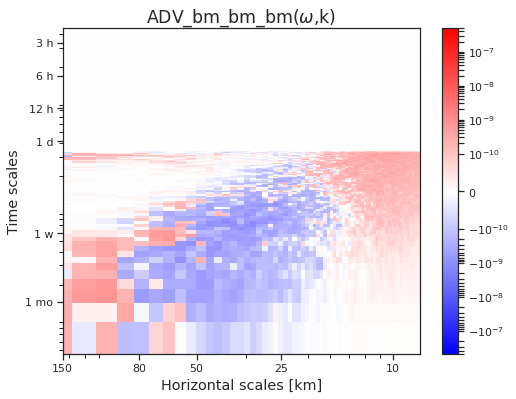

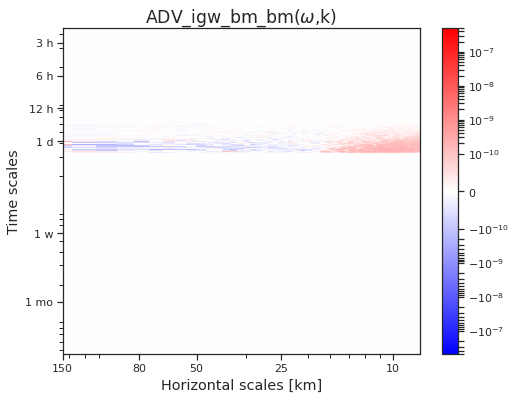

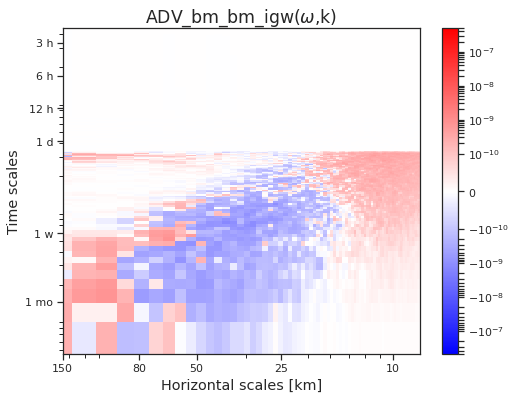

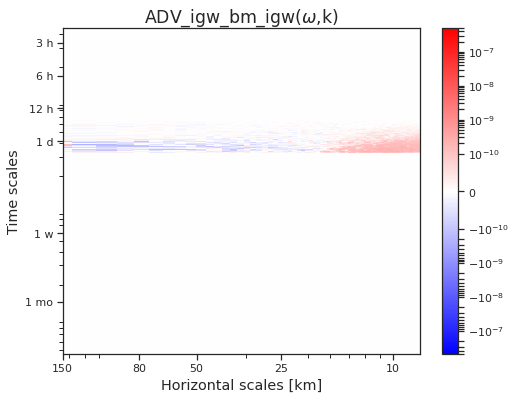

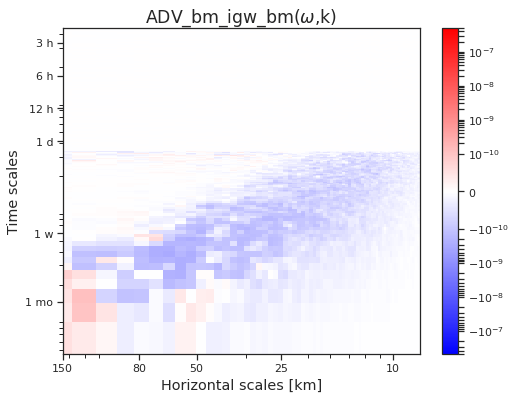

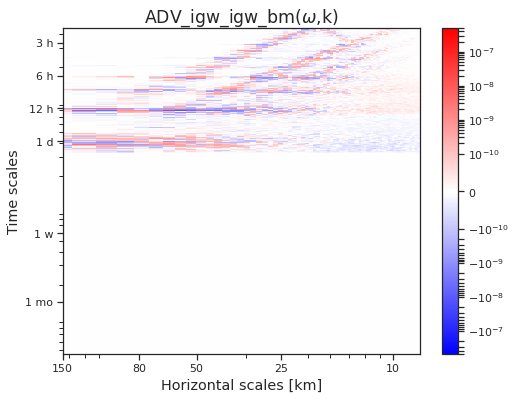

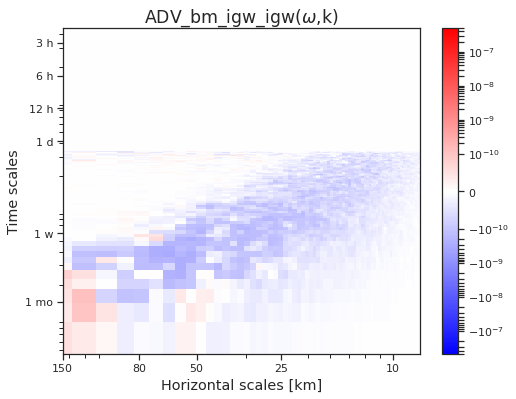

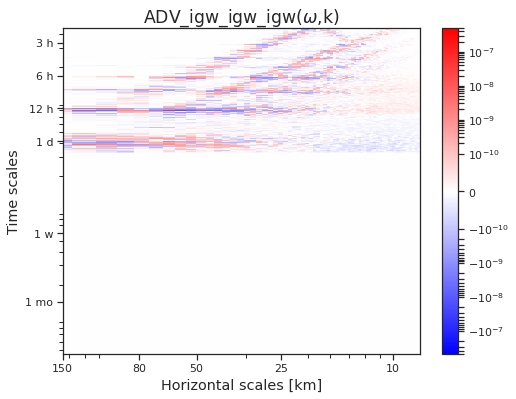

In [17]:
for s1,s2,co in itertools.product(["_bm","_igw"], repeat=3):
  calc_adv_cospec2d(reg_, coS=co, fromS=s1, toS=s2)